In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.io as pio

# Standard plotly imports
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)

In [3]:
from collections import Counter
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer
import operator 
from collections import defaultdict
import string
from nltk.tokenize.treebank import TreebankWordTokenizer


In [4]:

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [5]:
def create_aggregrated_plots(feature_name, target, bubble_size_adj=0.1 , aggregration='mean'):

    _tmp_material = train.groupby([target])[feature_name].mean()
    fig = go.Figure()
    color_values = list(_tmp_material.values.astype(int))
    tmp_trace = []

    fig.add_trace(go.Scatter(
        x=_tmp_material.index, y=_tmp_material.values.astype(int),
        marker=dict(
            size=_tmp_material.values.astype(int)*bubble_size_adj,
            color=color_values,
            colorbar=dict(
                title="Colorbar"
            ),
            colorscale="Viridis",
        ),
        mode="lines+markers")
    )

    fig.layout.update(
        title=go.layout.Title(
            text="Average "+feature_name + "/" + target,
        ),
        yaxis=dict(
                title='Average '+feature_name,
            ),
            xaxis=dict(
                title=target,
            )
    )

    iplot(fig)

In [6]:
def target_distribution(df , target, top_counts=None):
    if top_counts:
        topic_counts = df[target].astype(str).value_counts()[:top_counts]
    else:        
        topic_counts = df[target].astype(str).value_counts()
    
    fig = go.Figure([go.Bar(x=topic_counts.index, y=topic_counts.values, 
                            text=topic_counts.values,
                            textposition='auto' )])
    fig.layout.update(
            title=go.layout.Title(
                text="Topic Distribution",
            ),
            yaxis=dict(
                    title='Count',
                ),
                xaxis=dict(
                    title="Topic",
                )
        )
    iplot(fig)


In [7]:
def create_wordcloud(df, feature_names, target, target_filter):
    plt.figure(figsize=(25,10))
    for ei, feature_name in enumerate(feature_names):
        text = " ".join(review for review in df[df[target] == target_filter][feature_name])
        #print ("There are {} words in the combination of all {}.".format(len(text), feature_name))

        # Create the wordcloud object
        wordcloud = WordCloud(width=1024, height=480, margin=0).generate(text)

        # Display the generated image:
        plt.subplot(1,2,ei+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(feature_name)
        plt.margins(x=0, y=0)
    plt.show()

In [9]:
train_raw = pd.read_csv('/home/ubuntu/Desktop/Projects/Topic Modelling/docker-python-master/Dataset/train.csv')
test_raw = pd.read_csv('/home/ubuntu/Desktop/Projects/Topic Modelling/docker-python-master/Dataset/test.csv')

In [10]:
train = train_raw.copy()
test = test_raw.copy()

In [11]:
train.shape, test.shape

((5959, 3), (2553, 2))

In [12]:
train.head()

,Review Text,Review Title,topic
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture


In [13]:
test.head()

,Review Text,Review Title
0,I use chia seed in my protein shakes. These ta...,Bad tast
1,I use chia seed in my protein shakes. These ta...,Bad tast
2,Don’t waste your money.,No change. No results.
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"


# Handling Missing Values:

In [14]:
train.isnull().sum()

Review Text     0
Review Title    0
topic           0
dtype: int64

In [15]:
test.isnull().sum()

Review Text     0
Review Title    0
dtype: int64

# Feature Engineering

In [16]:
train['info'] = train['Review Text'] + " " + train['Review Title']
test['info'] = test['Review Text'] + " " + test['Review Title']


train['review_length'] = train['Review Text'].apply(lambda x: len(x))
train['review_word_count'] = train['Review Text'].apply(lambda x: len(x.split()))

train['title_length'] = train['Review Title'].apply(lambda x: len(x))
train['title_word_count'] = train['Review Title'].apply(lambda x: len(x.split()))


In [17]:
train.head()

,Review Text,Review Title,topic,info,review_length,review_word_count,title_length,title_word_count
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery,"Did nothing for me, didn't help lost even with...",112,19,7,1
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective,"Did nothing for me, didn't help lost even with...",112,19,7,1
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service,I have bought these bags and immediately open...,243,48,54,11
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic,Gave me an allergic reaction on my face :( Do ...,42,9,16,3
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture,These don't compare to the name brand wipes. F...,318,61,23,4


In [18]:
train.shape, test.shape

((5959, 8), (2553, 3))

# TARGET DISTRIBUTION

In [19]:
target_distribution(train, 'topic')

# Length of Review Text , Review Title

In [20]:
create_aggregrated_plots('review_length','topic',0.2)

In [21]:
create_aggregrated_plots('title_length', 'topic',1)

# Word Count of Review Text , Review Title

In [22]:
create_aggregrated_plots('review_word_count', 'topic', 1)

In [23]:
create_aggregrated_plots('title_word_count', 'topic',10)

In [24]:
train.title_word_count.max(),train.title_word_count.min() , train.title_word_count.mean()

(20, 1, 4.395368350394362)

# Important words in Review Text, Review Title for 'Bad Taste/Flavor'

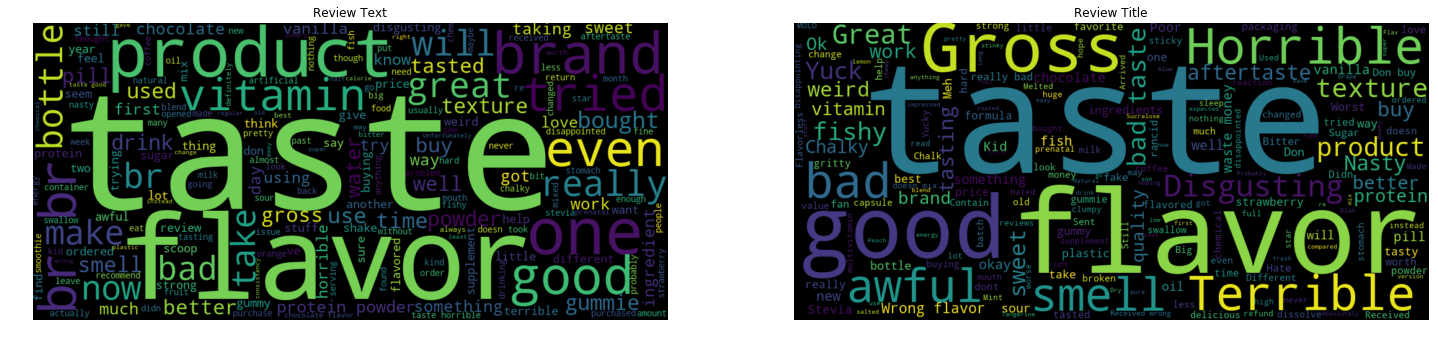

In [25]:
create_wordcloud(train, ["Review Text", "Review Title"], "topic", 'Bad Taste/Flavor')

# Important words in Review Text, Review Title for 'Packaging'

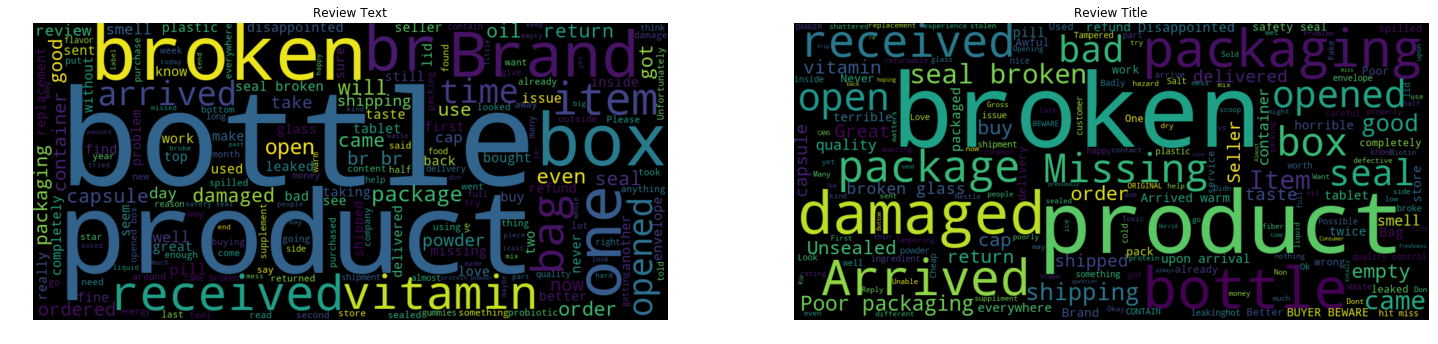

In [26]:
create_wordcloud(train,['Review Text', 'Review Title'],'topic', 'Packaging')


# Important words in Review Text, Review Title for 'Expiry'

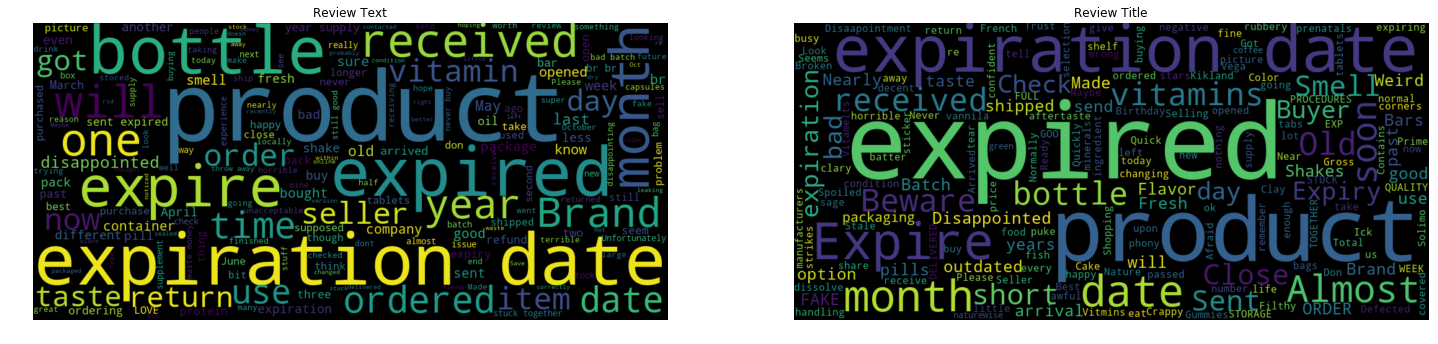

In [27]:
create_wordcloud(train, ['Review Text', 'Review Title'],'topic', 'Expiry')

# Explore data more...

In [28]:
repeated_reviews = train['Review Text'].value_counts()

In [29]:
repeated_reviews.head()

I usually buy my protein powder from GNC but I finally decided to purchase them from "X Brand" due to the low cost. I purchased 5 pounds of the double rich chocolate which proved to be a horrendous mistake. Firstly, I could tell it was not sealed tightly as it made a huge mess when I opened the container. Secondly and most importantly, the formula tasted awful, I don’t know if it is a bad batch or if they changed their ingredients but the double rich chocolate I’ve been using from GNC had some flavor. This one was disgusting, there was no hint of chocolate and I felt very unpleasant after drinking it. I was basically drinking water with a bad aftertaste. Do not buy the double rich chocolate or you’ll regret it, now I’m stuck with 5 pounds of useless powder.                                                                                               6
Their website would have you believe that only "trace amounts" of arsenic and lead are found in this protein powder. Apparently, poison 

In [30]:
train[train['Review Text'] == repeated_reviews.index[0]]

,Review Text,Review Title,topic,info,review_length,review_word_count,title_length,title_word_count
4876,I usually buy my protein powder from GNC but I...,Not Gold Standard,Too big to swallow,I usually buy my protein powder from GNC but I...,767,142,17,3
4877,I usually buy my protein powder from GNC but I...,Not Gold Standard,Texture,I usually buy my protein powder from GNC but I...,767,142,17,3
4878,I usually buy my protein powder from GNC but I...,Not Gold Standard,Not Effective,I usually buy my protein powder from GNC but I...,767,142,17,3
4879,I usually buy my protein powder from GNC but I...,Not Gold Standard,Quality/Contaminated,I usually buy my protein powder from GNC but I...,767,142,17,3
4880,I usually buy my protein powder from GNC but I...,Not Gold Standard,Bad Taste/Flavor,I usually buy my protein powder from GNC but I...,767,142,17,3
4881,I usually buy my protein powder from GNC but I...,Not Gold Standard,Customer Service,I usually buy my protein powder from GNC but I...,767,142,17,3


From the above output it is very clear that for same *Review Text* and *Review Title* we have different topics. So we can assume that it is a **multi label classification problem.**

# Make training data suitable for MULTI LABEL CLASSIFICATION problem.

In [31]:
multi_label_data = defaultdict(list)

for key, grp in train.groupby(['Review Text','Review Title']):
    multi_label_data['Review Text'].append(key[0])
    multi_label_data['Review Title'].append(key[1])
    multi_label_data['topic'].append(list(grp.topic.values))

In [32]:
multi_label_df = pd.DataFrame(multi_label_data)

In [33]:
multi_label_df['info'] = multi_label_df['Review Text'] +" "+ multi_label_df['Review Title']

In [34]:
multi_label_df.head()

,Review Text,Review Title,topic,info
0,!!!!!!--->>300 mg of sodium per 1 scoop servin...,Way too much sodium per serving,[Shipment and delivery],!!!!!!--->>300 mg of sodium per 1 scoop servin...
1,"""Is it really true that ""Garden of Life sold o...",SOLD OUT TO NESTLE AND REFUSES TO CORRECT THE ...,"[Ingredients, Bad Taste/Flavor, Allergic]","""Is it really true that ""Garden of Life sold o..."
2,"""X Brand"" Brand Revly Vegan Prenatal multivita...",Contraindications about excessive folic acid i...,"[Quality/Contaminated, Not Effective, Ingredie...","""X Brand"" Brand Revly Vegan Prenatal multivita..."
3,"""X Brand"" said the package was handed to the r...",Package has not been delivered. Need the packa...,[Shipment and delivery],"""X Brand"" said the package was handed to the r..."
4,"""X Brand"" says ""Package was left inside the re...",Never received the item.,[Shipment and delivery],"""X Brand"" says ""Package was left inside the re..."


In [35]:
mul_binarizer = MultiLabelBinarizer()
mul_binarizer.fit(multi_label_df.topic)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [36]:
mul_binarizer.classes_

array(['Allergic', 'Bad Taste/Flavor', 'Color and texture',
       'Customer Issues', 'Customer Service', "Didn't Like", 'Expiry',
       'False Advertisement', 'Hard to Chew', 'Inferior to competitors',
       'Ingredients', 'Not Effective', 'Packaging', 'Pricing',
       'Quality/Contaminated', 'Shipment and delivery', 'Smells Bad',
       'Texture', 'Too Sweet', 'Too big to swallow',
       'Wrong Product received'], dtype=object)

In [37]:
y_trans = mul_binarizer.transform(multi_label_df.topic)

In [38]:
y_trans

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [39]:
target_distribution(multi_label_df, 'topic', 30)

# Pre-trained Embeddings

In [42]:
GLOVE_EMBEDDING_FILE = '/home/ubuntu/Desktop/Projects/Topic Modelling/glove.840B.300d.txt'

In [44]:
FASTTEXT_EMBEDDING_FILE = '/home/ubuntu/Desktop/Projects/Topic Modelling/crawl-300d-2M.vec'

In [45]:
WIKI_EMBEDDING_FILE =     '/home/ubuntu/Desktop/Projects/Topic Modelling/wiki-news-300d-1M.vec'

In [46]:
EMBEDDING_FILES = [
    GLOVE_EMBEDDING_FILE,
    FASTTEXT_EMBEDDING_FILE,
    WIKI_EMBEDDING_FILE
]

# Do pre-processing by comparing Embedding Coverage

In [43]:
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
print(f'loaded {len(glove_embeddings)} word vectors ')

loaded 2196007 word vectors 


In [47]:
vocab = build_vocab(list(multi_label_df['info'].apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 55.82% of vocab
Found embeddings for  90.70% of all text


[('/><br', 464),
 ('"X', 455),
 ('Brand"', 353),
 ('I’m', 210),
 ('don’t', 180),
 ('I’ve', 166),
 ('it’s', 165),
 ('/>I', 162),
 ('didn’t', 142),
 ('doesn’t', 97)]

We can see html tags, let's remove those.

In [48]:
def preprocessing(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext.split()

In [49]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocessing)))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 57.30% of vocab
Found embeddings for  91.41% of all text


[('"X', 455),
 ('Brand"', 353),
 ('I’m', 210),
 ('don’t', 180),
 ('I’ve', 166),
 ('it’s', 165),
 ('didn’t', 142),
 ('doesn’t', 97),
 ('can’t', 92),
 ('It’s', 91)]

In [50]:
tokenizer = TreebankWordTokenizer()

In [51]:
def preprocess_2(x):
    x = ' '.join(preprocessing(x))
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    return x.split()

In [52]:
preprocess_2("I didn't know")

['I', 'did', "n't", 'know']

In [53]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocess_2)))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 79.07% of vocab
Found embeddings for  97.83% of all text


[('vitamins.', 49),
 ('Solimo', 45),
 ('refund.', 45),
 ('swallow.', 39),
 ('powder.', 36),
 ('gummies.', 31),
 ('packaging.', 26),
 ('container.', 24),
 ('..', 24),
 ('supplement.', 23)]

In [54]:
"protein.".replace(".","")

'protein'

In [55]:
def preprocess_3(x):
    x = ' '.join(preprocessing(x))
    x = x.replace('.',' ')
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    return x.split()

In [56]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocess_3)))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 92.02% of vocab
Found embeddings for  99.51% of all text


[('Solimo', 46),
 ('Revly', 13),
 ('vitafusion', 9),
 ('🤢', 7),
 ('50+', 5),
 ('+/-', 5),
 ('LASERSHIP', 5),
 ('VIDEOID', 4),
 ('mykind', 4),
 ('//www', 4)]

In [57]:
def preprocess_4(x):
    x = ' '.join(preprocessing(x))
    x = x.replace('.',' ')
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    x = re.sub('[+/-]', ' ', x)
    return x.split()

In [58]:
preprocess_4('pill/capsule/softgel/etc')

['pill', 'capsule', 'softgel', 'etc']

In [59]:
preprocess_4('softgel-')

['softgel']

In [60]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocess_4)))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 95.24% of vocab
Found embeddings for  99.71% of all text


[('Solimo', 46),
 ('Revly', 13),
 ('vitafusion', 9),
 ('🤢', 7),
 ('LASERSHIP', 5),
 ('VIDEOID', 4),
 ('mykind', 4),
 ('notropics', 3),
 ('Sleep3', 3),
 ('Testazone', 3)]

In [61]:
white_list = string.ascii_letters + string.digits + ' '
white_list += "'"

In [62]:
white_list

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 '"

In [63]:
glove_chars = ''.join([c for c in tqdm(glove_embeddings) if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])
glove_symbols

',.":)(-!?|;$&/[]>%=#*+\\•~@£·_{}©^®`<→°€™›♥←×§″′Â█½à…“★”–●â►−¢²¬░¡¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸¾Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡√◄━⇒▶º≥╝♡◊。✈≡☺✔↵≈ã✓Ð♣☎℃◦ø└‟Å～！○◆№♠▌✿▸⁄□É❖í✦．÷｜À┃å／￥╠↩✭▐☼µ☻┐Ó├ü«á∼┌℉☮฿≦♬✧〉－⌂✖･◕※‖◀‰\x97↺æ∆Ñœ┘┬╬،⌘š⊂Îª＞〈⎙Å？☠⇐▫∗∈≠♀ñƒ♔˚ç℗┗＊┼❀äı＆∩♂‿∑‣➜┛⇓☯⊖☀┳；∇⇑✰◇♯☞´ə↔┏｡ß◘∂Û✌♭ó┣┴┓✨ÖÄˈ˜❥┫Ü℠✒ž［∫\x93≧］\x94∀♛\x96∨◎ˑö↻⅓Æ⇩＜≫✩ˆ✪È♕Ù؟₤☛Ç╮␊＋┈ɡ％╋▽⇨┻þ⊗Á￡।▂✯▇＿➤ô₂✞＝▷△Þ◙î▅✝ﾟÏ∧␉☭ð┊╯☾➔ê∴\x92▃↳＾׳ú➢╭➡＠⊙ì☢˝Ô⅛∏ā„①๑∥❝Š☐▆Ÿûý╱⋙๏☁⇔▔\x91②➚◡Ê╰Ì٠ë♢Ý˙۞✘✮☑⋆ℓⓘ❒☣✉ē⌊➠∣❑⅔◢Òòⓒ\x80〒Í∕▮⦿✫✚⋯♩☂ˌ❞‗č܂☜ī‾✜╲ù∘⟩ō＼⟨·⅜✗Ă♚∅Ëⓔ◣͡‛❦⑨③◠✄❄１∃␣≪｢≅◯☽２İ∎｣⁰❧̅ÿǡⒶ↘⚓▣˘∪⇢Ú✍ɛ⊥＃⅝⎯õ↠۩☰Õ◥⊆✽ﬁ⚡↪ở❁☹ł◼☃◤❏Žⓢ⊱α➝̣✡∠｀▴┤Ȃ∝♏ⓐ✎;３④␤＇❣⅞✂✤ⓞ☪✴⌒˛♒＄ɪ✶▻Ⓔ◌◈۲Ʈ❚ʿ❂￦◉╜̃ťν✱╖❉₃ⓡℝ٤↗❶ʡ۰ˇⓣ♻➽۶₁ʃ׀✲Đʤ✬☉▉≒☥⌐♨✕ⓝ⊰❘＂⇧̵➪４▁βđ۱▏⊃ⓛ‚♰́✏⏑Œ̶٩Ⓢー⩾日￠❍≃⋰♋ɿ､̂ǿ❋✳ⓤ╤▕⌣✸℮⁺▨⑤╨Ⓥ♈❃☝Ā５✻⊇≻♘♞◂７✟Łū⌠✠☚✥ŋ❊ƂⒸŮ⌈❅Ⓡ♧Ⓞɑλ۵▭❱Ⓣ∟☕♺∵⍝ⓑɔ✵ŕ✣ℤ年ℕ٭♆Ⓘⅆ∶⚜◞்✹Ǥȡ➥ᴥ↕ɂ̳∷✋į➧∋̿ͧʘ┅⥤⬆ǀμ₄⋱ʔ☄↖⋮۔♌Ⓛ╕♓ـ⁴❯♍▋ă✺⭐６✾♊➣▿Ⓑ♉Ａ⏠◾▹⑥⩽в↦ż╥⍵⌋։➨и∮⇥ⓗⒹ⁻ʊć⎝⌥⌉◔◑ǂ✼♎ℂ♐╪ɨ⊚☒⇤θВⓜ⎠Ｏ◐ǰ⚠╞ﬂş◗⎕ⓨ☟Ｉⓟ♟❈↬ⓓŞ◻♮❙а♤∉؛⁂例ČⓃ־♑╫╓╳⬅☔πɒɹ߂Ō☸ɐʻ┄╧ʌ׃８ʒ⎢ġ❆⋄⚫ħ̏☏➞͂␙Ⓤ◟Ƥąʕ̊Ȥ⚐✙は↙̾ωΔ℘ﾞ✷⑦φ⍺❌⊢▵✅ｗ９ⓖ☨▰ʹŢ╡Ⓜő☤∽╘Ű˹↨ȿ♙⬇♱ś⌡Ω⠀╛❕┉Ⓟ̀Ǩ♖ⓚ┆⑧⎜Śǹ◜⚾⤴✇╟⎛☩➲➟ⓥⒽŘ⏝Ŀ◃０₀╢月↯✆ĶĢ˃⍴Ĥ❇ũ⚽╒Ｃɻɤ̸ʼ♜☓Ｔ➳⇄γ☬⚑✐⁵δȭ⌃◅▢ｓȸ❐ě

In [64]:
review_chars = build_vocab(list(multi_label_df["info"]))
review_symbols = ''.join([c for c in review_chars if not c in white_list])
review_symbols

'!->,."(/)?<*[]:%’‘;&#😷$“”👎🏼éíó⭐️⬇—\xa0ç😭=‡`+🤦🏾\u200d♀\U0001f92e😉🙋🏽á–🤢😡…🌶😣ã，_~🏻\U0001f92c😞😔🤔🤤😢😳😥★½🙈@😂😕☹😤😒🙁😆'

In [65]:
symbols_to_delete = ''.join([c for c in review_symbols if not c in glove_symbols])
symbols_to_delete

'😷👎🏼️\xa0😭🤦🏾\u200d\U0001f92e😉🙋🏽🤢😡🌶😣🏻\U0001f92c😞😔🤔🤤😢😳😥🙈😂😕😤😒🙁😆'

In [66]:
def preprocess_5(x):
    x = ' '.join(preprocessing(x))
    x = x.replace('.',' ')
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    x = re.sub('[+/-]', ' ', x)

    x = "".join([ x[i] for i in range(len(x)) if x[i] not in symbols_to_delete])
    return x

In [67]:
preprocess_5("hello i'm")

"hello i 'm"

In [68]:
vocab = build_vocab(list(multi_label_df['info'].apply(preprocess_5).str.split()))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


Found embeddings for 95.59% of vocab
Found embeddings for  99.73% of all text


[('Solimo', 46),
 ('Revly', 13),
 ('vitafusion', 9),
 ('LASERSHIP', 5),
 ('VIDEOID', 4),
 ('mykind', 4),
 ('notropics', 3),
 ('Sleep3', 3),
 ('Testazone', 3),
 ('gummys', 3)]

In [69]:
unique_topics = mul_binarizer.classes_

In [70]:
train = multi_label_df
test = test[~test[['Review Text','Review Title']].duplicated()]

In [71]:
train.shape

(4217, 4)

In [72]:
test.shape

(1776, 3)

In [73]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [74]:
X_train = train['info'].apply(preprocess_5)
X_test = test['info'].apply(preprocess_5)

In [75]:
X_train.head()

0    ! ! ! ! ! !      > > 300 mg of sodium per 1 sc...
1    `` Is it really true that `` Garden of Life so...
2    `` X Brand '' Brand Revly Vegan Prenatal multi...
3    `` X Brand '' said the package was handed to t...
4    `` X Brand '' says `` Package was left inside ...
Name: info, dtype: object

In [76]:
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [77]:
n_unique_words = None
tokenizer = text.Tokenizer(num_words = n_unique_words)


In [78]:
tokenizer.fit_on_texts(list(X_train) + list(X_test))


In [79]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [80]:
X_train_len = [len(x) for x in X_train]

In [81]:
pd.Series(X_train_len).describe()

count    4217.000000
mean       52.596396
std        50.613159
min         2.000000
25%        20.000000
50%        38.000000
75%        68.000000
max       548.000000
dtype: float64

In [82]:
MAX_LEN = 100

X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

In [83]:
from keras.utils.np_utils import to_categorical

In [84]:
y = y_trans

In [85]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [86]:
len(tokenizer.word_index)

10518

In [87]:
EMBEDDING_FILES

['/home/ubuntu/Desktop/Projects/Topic Modelling/glove.840B.300d.txt',
 '/home/ubuntu/Desktop/Projects/Topic Modelling/crawl-300d-2M.vec',
 '/home/ubuntu/Desktop/Projects/Topic Modelling/wiki-news-300d-1M.vec']

In [88]:
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES[:]], axis=-1)


In [89]:
embedding_matrix.shape

(10519, 900)

In [90]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, Dropout, SpatialDropout1D, LSTM, GRU
from keras.layers import add, concatenate, Conv1D, MaxPooling1D, merge, CuDNNLSTM, CuDNNGRU
from keras.layers import Embedding 
from keras.callbacks import ModelCheckpoint 
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.utils import plot_model
from keras.initializers import Constant

In [91]:
MAX_WORDS = len(tokenizer.word_index) + 1

In [92]:
input_layer = Input(shape=(MAX_LEN,))
embed_layer = Embedding(MAX_WORDS, embedding_matrix.shape[1],   weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)(input_layer)
x = Bidirectional(GRU(64, return_sequences=True, dropout=0.5,recurrent_dropout=0.5))(embed_layer)
x = Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

x = concatenate([ avg_pool, max_pool])

preds = Dense(len(unique_topics), activation="sigmoid")(x)

model = Model(input_layer, preds)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 900)     9467100     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     370560      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 64)       24640       bidirectional_1[0][0]            
__________________________________________________________________________________________________
global_ave

In [93]:
EPOCHS = 25

In [94]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor='val_loss',patience=5, min_delta=0.0001, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='./model-weights.hdf5', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [
    earlystop, 
    model_checkpoint
]

In [95]:
history = model.fit(X_train, y, 
          batch_size=16, 
          epochs=EPOCHS, 
          verbose=1, 
          validation_split=0.2,
          callbacks= callbacks)

Train on 3373 samples, validate on 844 samples
Epoch 1/25
3373/3373 [==============================] - 75s 22ms/step - loss: 0.2126 - categorical_accuracy: 0.3943 - val_loss: 0.1547 - val_categorical_accuracy: 0.5344

Epoch 00001: val_loss improved from inf to 0.15472, saving model to ./model-weights.hdf5
Epoch 2/25
3373/3373 [==============================] - 29s 9ms/step - loss: 0.1286 - categorical_accuracy: 0.6585 - val_loss: 0.1028 - val_categorical_accuracy: 0.6505

Epoch 00002: val_loss improved from 0.15472 to 0.10282, saving model to ./model-weights.hdf5
Epoch 3/25
3373/3373 [==============================] - 32s 9ms/step - loss: 0.0857 - categorical_accuracy: 0.7311 - val_loss: 0.0770 - val_categorical_accuracy: 0.7180

Epoch 00003: val_loss improved from 0.10282 to 0.07697, saving model to ./model-weights.hdf5
Epoch 4/25
3373/3373 [==============================] - 32s 10ms/step - loss: 0.0644 - categorical_accuracy: 0.7625 - val_loss: 0.0639 - val_categorical_accuracy: 0.75

In [96]:
plot_model(model, to_file='model.png')

In [98]:
fig = go.Figure()
tmp_trace = []

fig.add_trace(go.Scatter(
    x=history.epoch, 
    y=history.history['categorical_accuracy'],
    name='train',

    mode="lines+markers")
)
fig.add_trace(go.Scatter(
    x=history.epoch, 
    y=history.history['val_categorical_accuracy'],
    name='validation',
    mode="lines+markers")
)


fig.layout.update(
    title=go.layout.Title(
        text="Model Accuracy",
    ),
    yaxis=dict(
            title='Categorical Accuracy',
        ),
        xaxis=dict(
            title="Epoch",
        )
)

iplot(fig)


In [99]:
fig = go.Figure()
tmp_trace = []

fig.add_trace(go.Scatter(
    x=history.epoch, 
    y=history.history['loss'],
    name='train',

    mode="lines+markers")
)
fig.add_trace(go.Scatter(
    x=history.epoch, 
    y=history.history['val_loss'],
    name='validation',
    mode="lines+markers")
)


fig.layout.update(
    title=go.layout.Title(
        text="Model Loss",
    ),
    yaxis=dict(
            title='Loss',
        ),
        xaxis=dict(
            title="Epoch",
        )
)

iplot(fig)


In [100]:
model.load_weights('model-weights.hdf5')

In [101]:
predict_topics = model.predict(X_test, verbose=1)

1776/1776 [==============================] - 7s 4ms/step


# How to handle top N ?
> If that review occurs once in the test data, submit the most correlated prediction. If the occurrence is 2, submit the top 2 topics. And so on.

In [102]:
output = test_raw[['Review Text', 'Review Title']].copy()
output['topic'] = np.nan

In [103]:
for i in range(test.shape[0]):
    review = test.iloc[i]['Review Text']
    title = test.iloc[i]['Review Title']
    output_filter = output[(output['Review Text'] == review) & (output['Review Title'] == title)]
    test_pred = predict_topics[i]
    test_topic = np.argsort(test_pred)[::-1]

    p_topics = [ unique_topics[_] for _ in test_topic][:output_filter.shape[0]]
    
    output.loc[output_filter.index, 'topic'] = p_topics

In [104]:
output.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Quality/Contaminated
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Inferior to competitors


In [105]:
output.topic.value_counts()

Bad Taste/Flavor           558
Quality/Contaminated       295
Not Effective              259
Allergic                   233
Packaging                  209
Texture                    177
Shipment and delivery      154
Color and texture           99
Customer Service            95
Ingredients                 91
Too big to swallow          84
Expiry                      70
Smells Bad                  63
Too Sweet                   47
Wrong Product received      37
Pricing                     31
Inferior to competitors     18
False Advertisement         13
Customer Issues              8
Hard to Chew                 7
Didn't Like                  5
Name: topic, dtype: int64

In [106]:
output.to_csv("./topic_prediction_multilabel_final_model.csv", index=False)